[View in Colaboratory](https://colab.research.google.com/github/ajoshiusc/lesion-detector/blob/master/main_autoencoder.ipynb)

In [1]:
!rm -rf ./lesion-detector

!git clone https://github.com/ajoshiusc/lesion-detector
!pip install nilearn
import nilearn.image
import sys
sys.path.insert(0, './lesion-detector/src')
import numpy as np


sys.path.insert(0, './lesion-detector/src/SpyderNet')
  
import numpy as np
from spydernet import train_model, mod_indep_rep
from datautils import read_data
import matplotlib.pyplot as plt
from google.colab import drive
from keras.callbacks import TensorBoard
from keras import optimizers

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

""" Main script that calls the functions objects"""
print('gdrive mounting')
drive.mount('/content/gdrive')
print('mounted')
""" Main script that calls the functions objects"""
data_dir = 'gdrive/My Drive/tracktbi_pilot'


window_size=35
data = read_data(
study_dir=data_dir, nsub=20, psize=[window_size, window_size], npatch_perslice=64)


Cloning into 'lesion-detector'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 275 (delta 9), reused 8 (delta 3), pack-reused 254
Receiving objects: 100% (275/275), 17.08 MiB | 12.68 MiB/s, done.
Resolving deltas: 100% (161/161), done.
    100% |████████████████████████████████| 983kB 9.1MB/s 
    100% |████████████████████████████████| 4.2MB 5.0MB/s 
  Running setup.py bdist_wheel for nibabel ... - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/7e/97/9b/7cf05225afac39de2dacef758fc06c0c0bdf3e6efb40fabb9c
Successfully built nibabel


Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15615210535848727408
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11281553818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1308255770423303812
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
gdrive mounting
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
mounted
subject 1 
subject 2 
subject 3 
subject 4 
subject 5 
subject 6 
subject 7 
subj

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

def auto_encoder(input_size):

    input_img = Input(shape=(input_size, input_size,3))  # adapt this if using `channels_first` image data format



    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    encoded = MaxPooling2D((2, 2), padding='same')(x)



    # at this point the representation is (7, 7, 32)



    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)

    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3,), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(3, (2, 2), activation='relu', padding='valid')(x)



    model = Model(input_img, decoded)
    opt = optimizers.adam(lr=0.001)
    model.compile(optimizer=opt, loss='mean_squared_error')



    return model

In [0]:
!pip install Tensorboard
from time import time
from keras.callbacks import TensorBoard
from keras import backend as K
#np.random.shuffle(data)
trainsize=np.floor((data.shape[0])*0.8)
testsize=np.floor((data.shape[0])*0.9)
#trainsize.astype(int)

train_data = data[0:int(trainsize), :, :, :]
val_data = data[int(trainsize):int(testsize), :, :, :]
test_data=data[int(testsize):, :, :, :]

model=auto_encoder(window_size)
model.fit(train_data,train_data,

                epochs=50,

                batch_size=128,

                shuffle=True,

                validation_data=(val_data, val_data),

               callbacks=[TensorBoard(log_dir='/tmp/tb')])


Train on 186368 samples, validate on 23296 samples
Epoch 1/50
186368/186368 [==============================] - 60s 320us/step - loss: 0.0075 - val_loss: 0.0049
Epoch 2/50
117888/186368 [=================>............] - ETA: 20s - loss: 0.0040

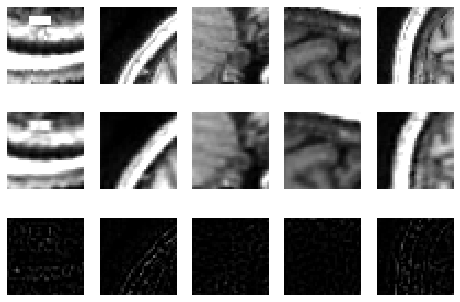

In [17]:
import sklearn 
x_test_noisy=test_data.copy()
x_test_noisy[5,4:8,10:20,0] = 1
decoded_imgs = model.predict(x_test_noisy)
plt.figure()
for j in range(5):
  ax=plt.subplot(3, 5, j + 1)
  plt.imshow(x_test_noisy[j+5, :, :, 0].squeeze(), vmin=0., vmax=1., cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(3, 5, 5 + j + 1)
  plt.imshow(decoded_imgs[j+5, :, :, 0].squeeze(),vmin=0., vmax=1., cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax=plt.subplot(3, 5, 10 + j + 1)
  plt.imshow(x_test_noisy[j+5, :, :, 0].squeeze()-decoded_imgs[j+5, :, :, 0].squeeze(),vmin=0., vmax=1., cmap='gray')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  

plt.show()

[[4, 5, 6], [1, 2, 3]]
